# TCP/IP Congestion Control Simulation
## Cloud Computing Assignment 1 — Q6
### PA-AIMD vs DCTCP vs Standard TCP AIMD

Run each cell in order (Shift+Enter). All 4 figures will appear inline and be saved as PNG files.

## Cell 1 — Imports & Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # fix seed so results are reproducible every run

LINK_CAPACITY = 100   # normalised bottleneck link capacity (Mbps)
MAX_CWND      = 100   # maximum congestion window size (packets)
ROUNDS        = 300   # number of simulation rounds per experiment

print('Setup OK')

Setup OK


## Cell 2 — Simulator Core
Discrete-round AIMD simulator with three congestion control modes:
- **TCP AIMD**: binary loss signal, 50% window halving on any loss
- **DCTCP**: ECN fraction α, fine-grained cwnd × (1 − α/2)  *(Alizadeh et al. 2010)*
- **PA-AIMD**: RTT-adaptive increase, predictive utilisation threshold, gentle 76% decrease

In [2]:
def jains_fairness(allocations):
    """Jain's Fairness Index: 1.0 = perfect fairness, lower = more unfair."""
    allocs = np.array(allocations)
    if allocs.sum() == 0:
        return 0.0
    return (allocs.sum()**2) / (len(allocs) * (allocs**2).sum())


def simulate_aimd(n_senders, loss_rate, ai=1.0, md=0.5,
                  dctcp=False, ecn_thresh=0.1,
                  pa_aimd=False, rtt_var=0.0,
                  rounds=ROUNDS):
    """
    Simulate n_senders sharing a bottleneck link over 'rounds' rounds.
    Returns: (cwnd_history, fairness_history, throughput_history)
    """
    cwnds = np.ones(n_senders) * 10.0  # all senders start at cwnd=10
    cwnd_history    = []
    fairness_hist   = []
    throughput_hist = []

    for r in range(rounds):

        # --- PA-AIMD: RTT-adaptive additive increase ---
        # High RTT variance (bursty AllReduce traffic) -> reduce increase rate
        # Formula: ai_eff = ai / (1 + |sigma_RTT|)
        if pa_aimd and rtt_var > 0:
            rtt_noise    = np.random.normal(0, rtt_var, n_senders)
            effective_ai = np.clip(ai / (1 + np.abs(rtt_noise)), 0.5, ai * 1.5)
        else:
            effective_ai = np.full(n_senders, ai)  # fixed increase for TCP and DCTCP

        # Additive increase phase: grow window each round
        cwnds      = np.minimum(cwnds + effective_ai, MAX_CWND)
        total_load = cwnds.sum()  # total demand across all senders

        if dctcp:
            # --- DCTCP: ECN-fraction based decrease (Alizadeh et al. 2010) ---
            # Switch marks packets when queue exceeds threshold K
            # Sender computes fraction alpha of marked packets
            # Window update: cwnd = cwnd * (1 - alpha/2)
            # This gives proportional response vs TCP's binary halving
            ecn_fraction = np.clip(
                (total_load - LINK_CAPACITY * (1 - ecn_thresh)) / LINK_CAPACITY, 0, 1)
            congested = np.random.rand(n_senders) < ecn_fraction
            cwnds = np.where(
                congested,
                np.maximum(cwnds * (1 - ecn_fraction / 2), 1),  # proportional decrease
                cwnds)

        elif pa_aimd:
            # --- PA-AIMD: predictive loss estimation ---
            # Estimate congestion from utilisation trend BEFORE a packet is dropped
            # If predicted utilisation > gamma (0.85), trigger proactive decrease
            # Gentle MD: md_eff = 0.4 * 0.6 = 0.24, so cwnd stays at 76% (vs 50% for TCP)
            # Justified because GPU cluster losses are often transient burst events
            predicted_loss = max(0, (total_load - LINK_CAPACITY) / LINK_CAPACITY)
            predicted_loss = np.clip(predicted_loss + loss_rate * 0.5, 0, 1)
            congested = np.random.rand(n_senders) < predicted_loss
            cwnds = np.where(
                congested,
                np.maximum(cwnds * (1 - md * 0.6), 1),  # gentle decrease to 76%
                cwnds)

        else:
            # --- Standard TCP AIMD: binary loss signal ---
            # Only reacts after a packet is dropped (too late for shallow DC buffers)
            # Halves cwnd on any loss -- overreacts to transient bursts
            if total_load > LINK_CAPACITY:
                prob_loss = loss_rate + (total_load - LINK_CAPACITY) / LINK_CAPACITY
            else:
                prob_loss = loss_rate
            congested = np.random.rand(n_senders) < np.clip(prob_loss, 0, 1)
            cwnds = np.where(congested, np.maximum(cwnds * md, 1), cwnds)  # halve on loss

        # Record per-round metrics
        cwnd_history.append(cwnds.copy())
        fairness_hist.append(jains_fairness(cwnds))
        throughput_hist.append(min(cwnds.sum(), LINK_CAPACITY))  # capped at link capacity

    return np.array(cwnd_history), np.array(fairness_hist), np.array(throughput_hist)


print('Simulator defined OK')

Simulator defined OK


## Figure 1 — Congestion Window Trajectories
2 senders, 200 rounds. Shows TCP sawtooth vs DCTCP fine-grained adjustments vs PA-AIMD smooth growth.

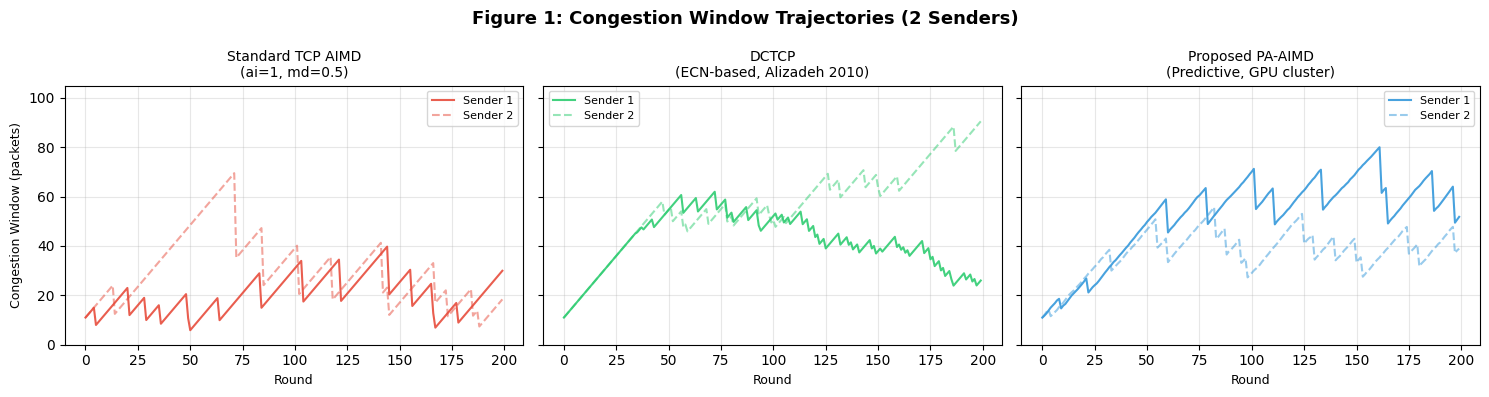

Figure 1 saved.


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle('Figure 1: Congestion Window Trajectories (2 Senders)', fontsize=13, fontweight='bold')

# Each scheme uses different parameters reflecting its design
configs = [
    ('Standard TCP AIMD\n(ai=1, md=0.5)',          dict(ai=1.0, md=0.5, loss_rate=0.05)),
    ('DCTCP\n(ECN-based, Alizadeh 2010)',           dict(ai=1.0, md=0.5, dctcp=True, loss_rate=0.02)),
    ('Proposed PA-AIMD\n(Predictive, GPU cluster)', dict(ai=1.2, md=0.4, pa_aimd=True, rtt_var=0.3, loss_rate=0.03)),
]
colors = ['#E74C3C', '#2ECC71', '#3498DB']

for ax, (title, params), color in zip(axes, configs, colors):
    hist, _, _ = simulate_aimd(n_senders=2, **params, rounds=200)
    ax.plot(hist[:, 0], color=color, alpha=0.9, label='Sender 1', linewidth=1.5)
    ax.plot(hist[:, 1], color=color, alpha=0.5, label='Sender 2', linewidth=1.5, linestyle='--')  # dashed = Sender 2
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Round', fontsize=9)
    ax.set_ylim(0, MAX_CWND + 5)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

axes[0].set_ylabel('Congestion Window (packets)', fontsize=9)
plt.tight_layout()
plt.savefig('fig1_cwnd_trajectory.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure 1 saved.')

## Figure 2 — Throughput vs Packet Loss Rate
5 senders, averaged over 300 rounds. PA-AIMD's gentle decrease preserves throughput at high loss rates.

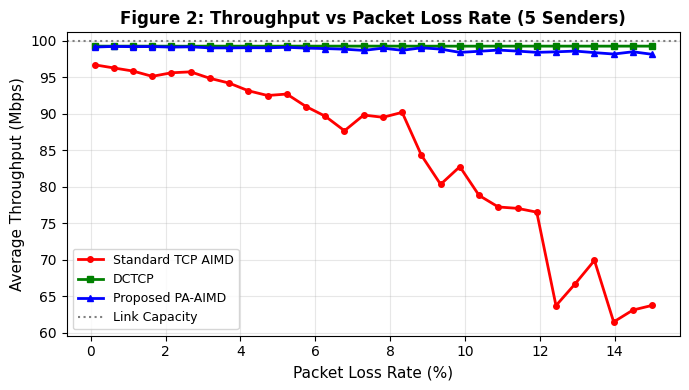

Figure 2 saved.


In [4]:
loss_rates = np.linspace(0.001, 0.15, 30)  # sweep from 0.1% to 15% loss
tput_tcp, tput_dctcp, tput_pa = [], [], []

for lr in loss_rates:
    _, _, t = simulate_aimd(5, loss_rate=lr, ai=1.0, md=0.5)
    tput_tcp.append(t.mean())  # average throughput over all rounds
    _, _, t = simulate_aimd(5, loss_rate=lr, dctcp=True, ai=1.0, md=0.5)
    tput_dctcp.append(t.mean())
    _, _, t = simulate_aimd(5, loss_rate=lr, pa_aimd=True, ai=1.2, md=0.4, rtt_var=0.3)
    tput_pa.append(t.mean())

plt.figure(figsize=(7, 4))
plt.plot(loss_rates * 100, tput_tcp,   'r-o', markersize=4, label='Standard TCP AIMD', linewidth=2)
plt.plot(loss_rates * 100, tput_dctcp, 'g-s', markersize=4, label='DCTCP',             linewidth=2)
plt.plot(loss_rates * 100, tput_pa,    'b-^', markersize=4, label='Proposed PA-AIMD',  linewidth=2)
plt.axhline(y=LINK_CAPACITY, color='gray', linestyle=':', linewidth=1.5, label='Link Capacity')
plt.xlabel('Packet Loss Rate (%)', fontsize=11)
plt.ylabel('Average Throughput (Mbps)', fontsize=11)
plt.title('Figure 2: Throughput vs Packet Loss Rate (5 Senders)', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fig2_throughput_vs_loss.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure 2 saved.')

## Figure 3 — Jain's Fairness Index vs Number of Senders
Loss rate = 4%, 300 rounds. Higher = fairer bandwidth sharing between senders.

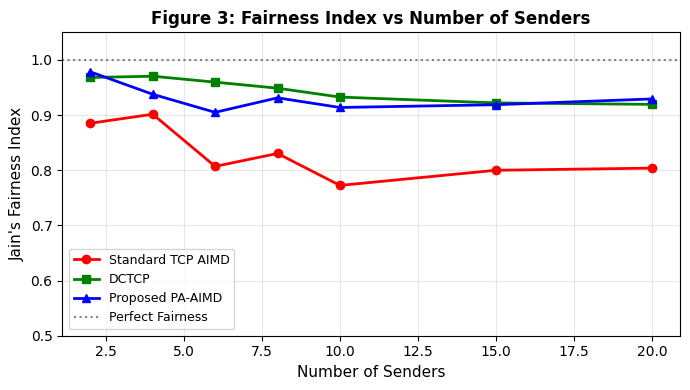

Figure 3 saved.


In [5]:
sender_counts = [2, 4, 6, 8, 10, 15, 20]  # test across increasing number of competing senders
fair_tcp, fair_dctcp, fair_pa = [], [], []

for n in sender_counts:
    _, f, _ = simulate_aimd(n, loss_rate=0.04, ai=1.0, md=0.5)
    fair_tcp.append(f.mean())   # average Jain index over all rounds
    _, f, _ = simulate_aimd(n, loss_rate=0.04, dctcp=True, ai=1.0, md=0.5)
    fair_dctcp.append(f.mean())
    _, f, _ = simulate_aimd(n, loss_rate=0.04, pa_aimd=True, ai=1.2, md=0.4, rtt_var=0.3)
    fair_pa.append(f.mean())

plt.figure(figsize=(7, 4))
plt.plot(sender_counts, fair_tcp,   'r-o', markersize=6, label='Standard TCP AIMD', linewidth=2)
plt.plot(sender_counts, fair_dctcp, 'g-s', markersize=6, label='DCTCP',             linewidth=2)
plt.plot(sender_counts, fair_pa,    'b-^', markersize=6, label='Proposed PA-AIMD',  linewidth=2)
plt.axhline(y=1.0, color='gray', linestyle=':', linewidth=1.5, label='Perfect Fairness')
plt.xlabel('Number of Senders', fontsize=11)
plt.ylabel("Jain's Fairness Index", fontsize=11)
plt.ylim(0.5, 1.05)
plt.title("Figure 3: Fairness Index vs Number of Senders", fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fig3_fairness_vs_senders.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure 3 saved.')

## Figure 4 — Cold Start Convergence
Rounds for ALL senders (starting at cwnd=1) to reach 80% link utilisation.
Averaged over 50 trials. Models a GPU training job launching from scratch.

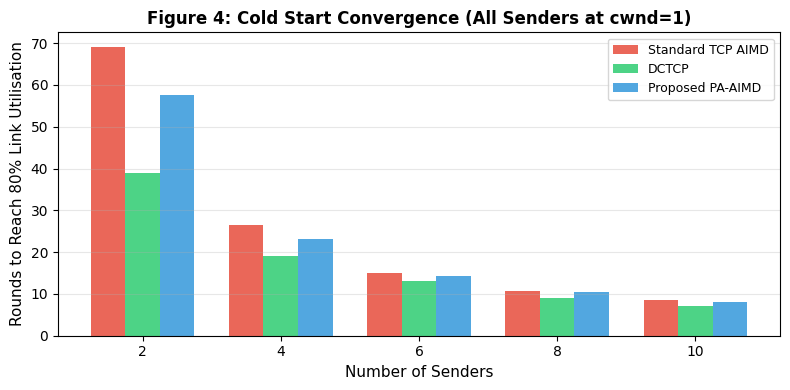

Figure 4 saved.


In [6]:
def cold_start_time(n_senders, threshold=0.80, **kwargs):
    """Count rounds until aggregate utilisation reaches threshold. Max 500 rounds."""
    cwnds   = np.ones(n_senders)  # all senders start at cwnd=1 (cold start)
    ai      = kwargs.get('ai', 1.0)
    md      = kwargs.get('md', 0.5)
    loss    = kwargs.get('loss_rate', 0.04)
    pa      = kwargs.get('pa_aimd', False)
    dctcp   = kwargs.get('dctcp', False)
    rtt_var = kwargs.get('rtt_var', 0.0)

    for r in range(500):
        # Check if aggregate utilisation has reached the 80% target
        if min(cwnds.sum(), LINK_CAPACITY) / LINK_CAPACITY >= threshold:
            return r

        # RTT-adaptive increase (PA-AIMD only)
        if pa and rtt_var > 0:
            rtt_noise = np.random.normal(0, rtt_var, n_senders)
            eff_ai    = np.clip(ai / (1 + np.abs(rtt_noise)), 0.5, ai * 1.5)
        else:
            eff_ai = np.full(n_senders, ai)

        cwnds      = np.minimum(cwnds + eff_ai, MAX_CWND)
        total_load = cwnds.sum()

        if dctcp:
            # DCTCP ECN-based decrease
            ecn_fraction = np.clip((total_load - LINK_CAPACITY * 0.9) / LINK_CAPACITY, 0, 1)
            congested = np.random.rand(n_senders) < ecn_fraction
            cwnds = np.where(congested, np.maximum(cwnds * (1 - ecn_fraction / 2), 1), cwnds)
        elif pa:
            # PA-AIMD gentle decrease: cwnd stays at 76% rather than 50%
            prob = np.clip(loss + max(0, (total_load - LINK_CAPACITY) / LINK_CAPACITY), 0, 1) * 0.5
            congested = np.random.rand(n_senders) < prob
            cwnds = np.where(congested, np.maximum(cwnds * (md * 0.6), 1), cwnds)
        else:
            # TCP: binary halving on loss
            prob = np.clip(loss + max(0, (total_load - LINK_CAPACITY) / LINK_CAPACITY), 0, 1)
            congested = np.random.rand(n_senders) < prob
            cwnds = np.where(congested, np.maximum(cwnds * md, 1), cwnds)

    return 500  # did not converge within 500 rounds


n_vals = [2, 4, 6, 8, 10]
TRIALS = 50  # average over 50 random trials to reduce noise
conv_tcp, conv_dctcp, conv_pa = [], [], []

for n in n_vals:
    conv_tcp.append(np.mean([cold_start_time(n, loss_rate=0.04, ai=1.0, md=0.5) for _ in range(TRIALS)]))
    conv_dctcp.append(np.mean([cold_start_time(n, loss_rate=0.02, ai=1.0, md=0.5, dctcp=True) for _ in range(TRIALS)]))
    conv_pa.append(np.mean([cold_start_time(n, loss_rate=0.03, ai=1.2, md=0.4, pa_aimd=True, rtt_var=0.3) for _ in range(TRIALS)]))

x     = np.arange(len(n_vals))
width = 0.25  # width of each bar group
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width, conv_tcp,   width, label='Standard TCP AIMD', color='#E74C3C', alpha=0.85)
ax.bar(x,         conv_dctcp, width, label='DCTCP',             color='#2ECC71', alpha=0.85)
ax.bar(x + width, conv_pa,    width, label='Proposed PA-AIMD',  color='#3498DB', alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels([str(n) for n in n_vals])
ax.set_xlabel('Number of Senders', fontsize=11)
ax.set_ylabel('Rounds to Reach 80% Link Utilisation', fontsize=11)
ax.set_title('Figure 4: Cold Start Convergence (All Senders at cwnd=1)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('fig4_convergence.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure 4 saved.')

## All Done!
4 PNG files saved in the same folder:
- `fig1_cwnd_trajectory.png`
- `fig2_throughput_vs_loss.png`
- `fig3_fairness_vs_senders.png`
- `fig4_convergence.png`